In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras import layers

In [5]:
EMPRESA = 'ITUB4.SA'

## Funções

In [6]:
def dias_uteis_entre_datas(start_date,end_date):
    date_range = pd.date_range(start=start_date, end=end_date, freq='B')

    date_list = date_range.strftime('%Y-%m-%d').tolist()

    return date_list


In [7]:
def get_data_ticker(ticker, period='5y'):
    data_hist = yf.download(ticker, period=period)
    data_hist = pd.DataFrame(data_hist['Close'])
    data_hist['prev-day-1'] = data_hist['Close'].rolling(5).mean().shift(1)
    data_hist['prev-day-2'] = data_hist['Close'].rolling(5).mean().shift(2)
    data_hist['prev-day-3'] = data_hist['Close'].rolling(5).mean().shift(3)
    data_hist['mm_5'] = data_hist['Close'].rolling(5).mean()
    data_hist['mm_21'] = data_hist['Close'].rolling(21).mean()
    data_hist = data_hist.dropna()
    data_hist['tomorrow'] = data_hist['Close'].rolling(5).mean().shift(-1)
    return data_hist

In [8]:
def split_df_X_y(df_model):
    dates = df_model.index
    df_as_np = df_model.to_numpy()
    X = df_as_np[:,:-1]

    X = X.reshape(len(dates), X.shape[1], 1)
    y = df_as_np[:,-1]

    return (dates, X.astype(np.float32), y.astype(np.float32))

df_full = get_data_ticker(EMPRESA, period='5y')
df = df_full.dropna()
dates, X, y = split_df_X_y(df)

[*********************100%%**********************]  1 of 1 completed


In [9]:
def adiciona_nova_linha(df, novo_fechamento, data):
    new_row = {
            'Close': novo_fechamento,
            'prev-day-1': df.iloc[-1]['Close'] if len(df) >= 1 else None,
            'prev-day-2': df.iloc[-2]['Close'] if len(df) >= 2 else None,
            'prev-day-3': df.iloc[-3]['Close'] if len(df) >= 3 else None
        }

    new_index = pd.to_datetime(data)
    new_df = pd.DataFrame(new_row, index=[new_index])
    df = pd.concat([df, new_df])
    df['mm_5'] = df['Close'].rolling(5).mean()
    df['mm_21'] = df['Close'].rolling(21).mean()
    return df

In [10]:
def train_model_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([layers.Input((6,1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_feedforward(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Dense(64, activation='relu', input_dim=6))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_rnn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(layers.Input((6,1)))
    model.add(layers.SimpleRNN(40, return_sequences=True))
    model.add(layers.SimpleRNN(40))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

def train_model_cnn(X_train, y_train, X_test, y_test):
    # Create a CNN model
    model = Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1))

    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
    return model

In [11]:
def predict_tomorrow(model):
    last_day = get_data_ticker(EMPRESA, period='1mo') # Buscando um mes de dados pois as vezes quando coloco '1d' vem vazio :(
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(last_day)
    return model.predict(np.array([X_tomorrow[-1]]))

In [12]:
def predict_next_day(df,model):
    ultimo_registro = df.tail(1)
    date_tomorrow, X_tomorrow, y_tomorrow = split_df_X_y(ultimo_registro)
    return model.predict(np.array([X_tomorrow[-1]]),verbose=0)

In [13]:

# from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.pyplot as plt
# df: pd.DataFrame = get_data_ticker(EMPRESA, period='5y')[['Close']]
# df = df.asfreq('1d').fillna(0)
# result = seasonal_decompose(y, period=240, extrapolate_trend='freq')
# print(result.trend)
# print(result.seasonal)
# print(result.resid)
# print(result.observed)
# result.plot()
# plt.show()

## Pré-processamento

In [14]:
range_80 = int(len(dates)*.85)
range_90 = int(len(dates)*.95)

dates_train, X_train, y_train = dates[:range_80], X[:range_80], y[:range_80]
dates_test, X_test, y_test = dates[range_80:range_90], X[range_80:range_90], y[range_80:range_90]
dates_validation, X_validation, y_validation = dates[range_90:], X[range_90:], y[range_90:]

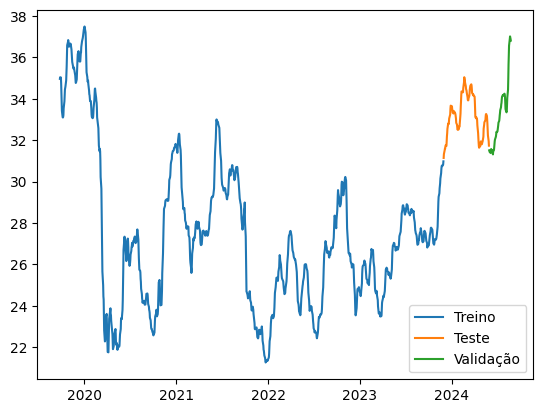

In [15]:
plt.plot(dates_train,y_train, label='Treino')
plt.plot(dates_test,y_test, label='Teste')
plt.plot(dates_validation,y_validation, label='Validação')
plt.legend()

## LSTM

Resultado com dados nunca vistos pelo modelo

In [16]:
model_lstm = train_model_lstm(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_lstm)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 747.9879 - mean_absolute_error: 27.1122 - val_loss: 1010.4515 - val_mean_absolute_error: 31.7719
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 613.9402 - mean_absolute_error: 24.4474 - val_loss: 505.9890 - val_mean_absolute_error: 22.4712
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 162.1638 - mean_absolute_error: 11.6071 - val_loss: 16.0513 - val_mean_absolute_error: 3.8776
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 16.4789 - mean_absolute_error: 3.3996 - val_loss: 39.6175 - val_mean_absolute_error: 6.2168
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 12.6716 - mean_absolute_error: 2.7707 - val_loss: 34.2331 - val_mean_absolute_error: 5.7683
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.9732 - mean_absolute_error: 2.6507 - val_loss: 29.1660 - val_mean_absolute_error: 5.3144
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11.2618 - mean_absolute

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


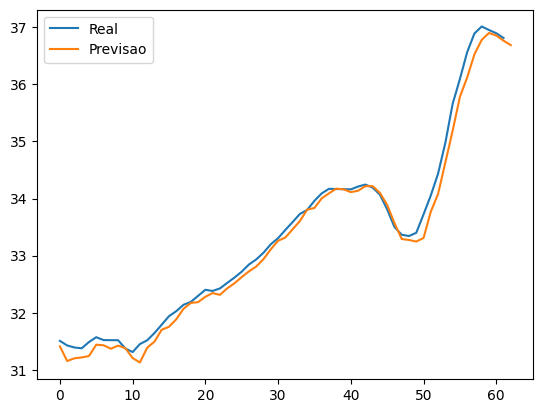

In [17]:
y_pred = model_lstm.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()

## FeedForward

In [18]:
model_feedforward = train_model_feedforward(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_feedforward)

Epoch 1/100


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 185.1744 - mean_absolute_error: 11.1736 - val_loss: 0.7944 - val_mean_absolute_error: 0.8522
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0280 - mean_absolute_error: 0.8390 - val_loss: 0.3394 - val_mean_absolute_error: 0.5235
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2282 - mean_absolute_error: 0.3702 - val_loss: 0.0650 - val_mean_absolute_error: 0.2131
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1529 - mean_absolute_error: 0.2990 - val_loss: 0.0643 - val_mean_absolute_error: 0.2116
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1639 - mean_absolute_error: 0.3049 - val_loss: 0.0634 - val_mean_absolute_error: 0.2103
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1423 - mean_absolute_error: 0.2909 - val_loss: 0.0860 - val_mean_absolute_error: 0.2408
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1620 - mean_absolute_error: 0.3068 - val_loss: 0.0623 

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


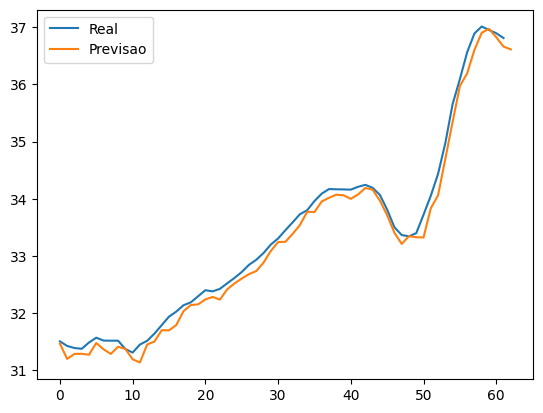

In [19]:
y_pred = model_feedforward.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()

## RNN

In [20]:
model_rnn = train_model_rnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_rnn)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 625.7122 - mean_absolute_error: 24.6897 - val_loss: 690.1526 - val_mean_absolute_error: 26.2522
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 402.0349 - mean_absolute_error: 19.7129 - val_loss: 570.6450 - val_mean_absolute_error: 23.8678
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 326.8695 - mean_absolute_error: 17.7313 - val_loss: 506.1693 - val_mean_absolute_error: 22.4766
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 279.1436 - mean_absolute_error: 16.3106 - val_loss: 449.9780 - val_mean_absolute_error: 21.1898
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 240.9351 - mean_absolute_error: 15.0676 - val_loss: 399.8694 - val_mean_absolute_error: 19.9724
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 204.3046 - mean_absolute_error: 13.8325 - val_loss: 355.4588 - val_mean_absolute_error: 18.8278
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 172.8565 -

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


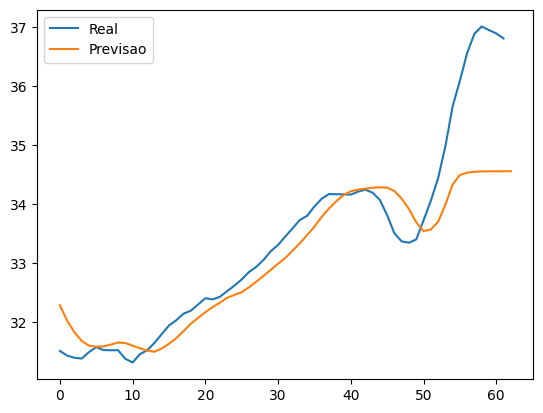

In [21]:
y_pred = model_rnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()

## CNN

In [22]:
model_cnn = train_model_cnn(X_train, y_train, X_test, y_test)
y_tomorrow = predict_tomorrow(model_cnn)

Epoch 1/100


C:\Users\teixe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 223.3803 - mean_absolute_error: 12.6400 - val_loss: 1.9300 - val_mean_absolute_error: 1.3448
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6540 - mean_absolute_error: 1.0808 - val_loss: 0.4081 - val_mean_absolute_error: 0.5429
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4877 - mean_absolute_error: 0.5047 - val_loss: 0.1225 - val_mean_absolute_error: 0.2864
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3979 - mean_absolute_error: 0.4477 - val_loss: 0.1279 - val_mean_absolute_error: 0.2949
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3772 - mean_absolute_error: 0.4459 - val_loss: 0.1476 - val_mean_absolute_error: 0.3231
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3828 - mean_absolute_error: 0.4376 - val_loss: 0.1499 - val_mean_absolute_error: 0.3261
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3598 - mean_absolute_error: 0.4183 - val_loss: 0.1350 

[*********************100%%**********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


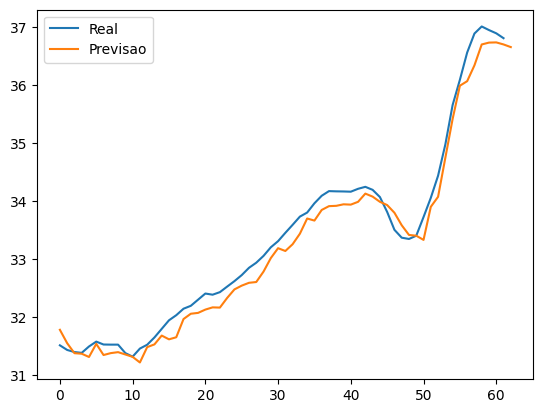

In [23]:
y_pred = model_cnn.predict(X_validation).flatten()
y_pred = [*y_pred, *y_tomorrow[-1]]

plt.plot(y_validation, label="Real")
plt.plot(pd.Series(y_pred), label="Previsao")
plt.legend()

## Previsão a longo prazo

In [24]:
modelos = [{
            'nome'   : 'LSTM',
            'modelo' : model_lstm
        },{
            'nome'   : 'Feed Forward',
            'modelo' : model_feedforward
        },{
            'nome'   : 'RNN',
            'modelo' : model_rnn
        },{
            'nome'   : 'CNN',
            'modelo' : model_cnn
        }]

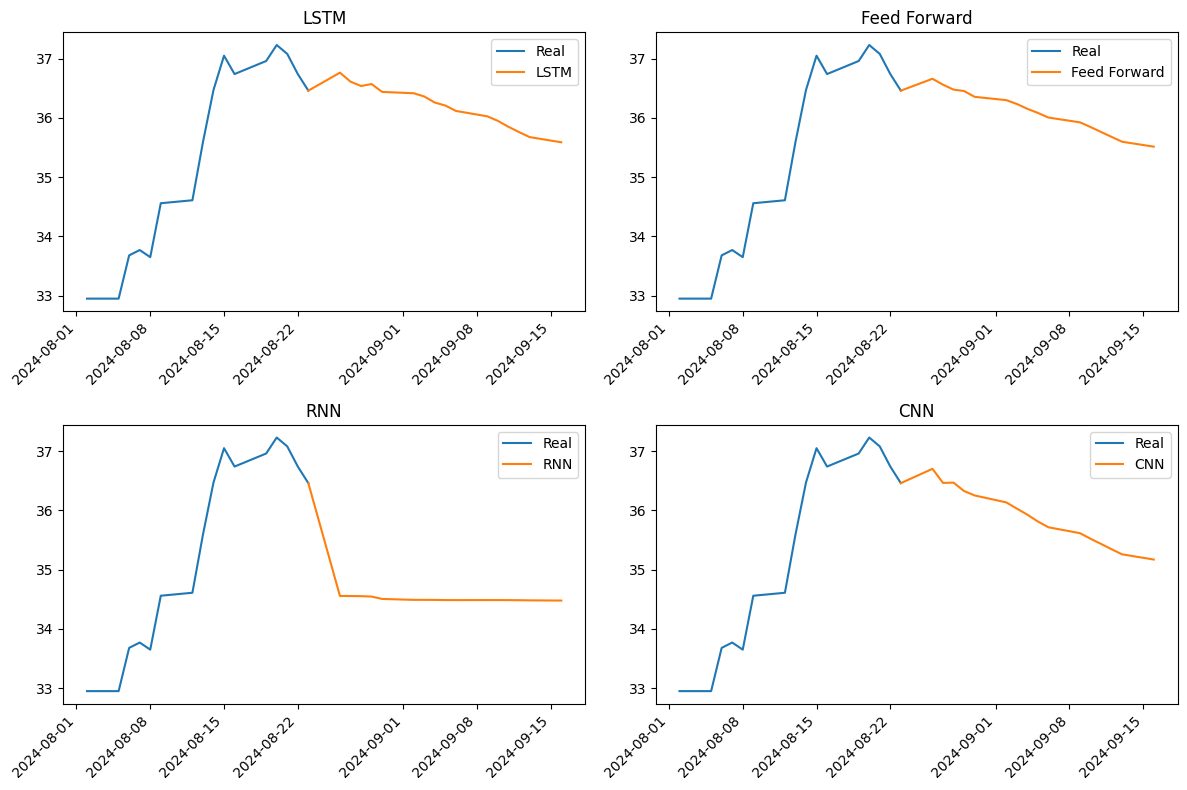

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, model in enumerate(modelos):
    df_copy = df.copy()
    dias_uteis = dias_uteis_entre_datas('2024-08-25', '2024-09-16')
    for dia in dias_uteis:
        proxima_predicao = float(predict_next_day(df_copy, model['modelo'])[-1])
        df_copy.iloc[-1, df.columns.get_loc('tomorrow')] = proxima_predicao
        df_copy = adiciona_nova_linha(df_copy, proxima_predicao, dia)

    ax = axs[i//2, i%2] 

    ax.set_title(model['nome'])
    ax.plot(df_copy[-(len(dias_uteis)+(int(len(dias_uteis)/1))):-len(dias_uteis)]['Close'], label='Real')
    ax.plot(df_copy[-len(dias_uteis)-1:]['Close'], label=model['nome'])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend()

plt.tight_layout()
plt.show()